<a id="plan"></a>

## Modelling with a basic preprocessing

-  [Preprocessing and downcasting training data](#prepdowntraining)
-  [RF with no tuning](#classicrf)
-  [Preprocessing and downcasting testing data](#prepdowntesting)
-  [Performance evaluation](#performance)
-  [Conclusion](#conclude)

Having too good results on a company-specific model, I decided to check if my preprocessing has ever introduced any positive impact to the model. Beneath is still some "basic" preprocessing, which could be done after just downloading the data and exploring it for 5 minutes, without digging too deep in what the data is.

[Bottom](#bottom)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import src.transformLargeDF as pr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
data_path = Path().resolve() / 'data'
df_train = pd.read_csv(data_path / 'GUIDE_Train.csv', low_memory=False)
df_test = pd.read_csv(data_path / 'GUIDE_Test.csv', low_memory=False)

<a id="prepdowntraining"></a>

### Preprocessing and downcasting training data

What was done under the name of `basic` preprocessing:
- Dropped duplicates
- Dropped None values from IncidentGrade (target) column, which are introduced only in training data (otherwise leaving it leads to 68% F1-macro and very poor curves)
- `add_date_columns` - slightly modified to this dataset function from a previous project
- `changeToCats` - function from a previous project
- `process_df` - function from a previous project

All functions are available for exploration in src/transformLargeDF.py

[Back to top](#plan)

In [4]:
df_train.drop_duplicates(inplace=True)
df_train.dropna(subset=['IncidentGrade'], inplace=True)
df_train['Timestamp'] = pd.to_datetime(df_train['Timestamp'])
pr.add_date_columns(df_train, ['Timestamp'])
pr.changeToCats(df_train)

cols_int64 = df_train.dtypes[df_train.dtypes == 'int64'].index
possible_integers = pd.Series([8, 16, 32, 64])

for i in cols_int64:
  value_max_log = np.log2(df_train[i].max())
  value_min_log = np.log2(abs(df_train[i].min()) + 1e-6)
  biggest_log = max(value_max_log, value_min_log)
  transform_to = possible_integers[possible_integers > biggest_log]
  df_train[i] = df_train[i].astype(f'int{transform_to.min()}')

cols_int32 = df_train.dtypes[df_train.dtypes == 'int32'].index
possible_integers = pd.Series([8, 16, 32])

for i in cols_int32:
  value_max_log = np.log2(df_train[i].max())
  value_min_log = np.log2(abs(df_train[i].min()) + 1e-6)
  biggest_log = max(value_max_log, value_min_log)
  transform_to = possible_integers[possible_integers > biggest_log]
  df_train[i] = df_train[i].astype(f'int{transform_to.min()}')

df_processed, y, nas = pr.process_df(df_train, 'IncidentGrade')

100%|██████████| 1/1 [00:02<00:00,  2.70s/it]
58it [00:04, 12.89it/s]


<a id="classicrf"></a>

### Fit random forest without tuning

All hyper-parameters are basic (same as in the company-specific model)

[Back to top](#plan)

In [5]:
classifier = RandomForestClassifier(
    random_state=42,
    n_jobs= -1
)

%time classifier.fit(df_processed, y)

CPU times: total: 1h 9min 15s
Wall time: 10min 6s


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<a id="prepdowntesting"></a>

### Preprocessing and downcasting testing data

Do all the same as in the training data section, except that we do not need to handle target column

[Back to top](#plan)

In [6]:
df_test.drop(labels=['Usage'], axis=1, inplace=True)
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])
pr.add_date_columns(df_test, ['Timestamp'])
pr.changeToCats(df_test)

cols_int64 = df_test.dtypes[df_test.dtypes == 'int64'].index
possible_integers = pd.Series([8, 16, 32, 64])
for i in cols_int64:
  value_max_log = np.log2(df_test[i].max())
  value_min_log = np.log2(abs(df_test[i].min()) + 1e-6)
  biggest_log = max(value_max_log, value_min_log)
  transform_to = possible_integers[possible_integers > biggest_log]
  df_test[i] = df_test[i].astype(f'int{transform_to.min()}')

cols_int32 = df_test.dtypes[df_test.dtypes == 'int32'].index
possible_integers = pd.Series([8, 16, 32])
for i in cols_int32:
  value_max_log = np.log2(df_test[i].max())
  value_min_log = np.log2(abs(df_test[i].min()) + 1e-6)
  biggest_log = max(value_max_log, value_min_log)
  transform_to = possible_integers[possible_integers > biggest_log]
  df_test[i] = df_test[i].astype(f'int{transform_to.min()}')

df_validate, y_validate, nas_validate = pr.process_df(df_test, 'IncidentGrade')

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
58it [00:01, 29.12it/s]


<a id="performance"></a>

### Performance evaluation

On average `9% of events are misclassified`, which is a significant failure in the context of the model. After my preprocessing in the same context the model `misclassifies events in 0.46% of cases`, which is `19.5 times better` or `9.4% better` in terms of accuracy and `9.9% better` in terms of F1-macro (which I am concentrating on). Therefore I can definitely say that my preprocessing had a positive impact on the model. By the way, having IncidentGrade target unexplored leads to `47% domination` of my preprocessing decisions and discoveries.

[Back to top](#plan)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92   1752940
           1       0.92      0.83      0.87    902698
           2       0.94      0.91      0.93   1492354

    accuracy                           0.91   4147992
   macro avg       0.92      0.90      0.91   4147992
weighted avg       0.91      0.91      0.91   4147992



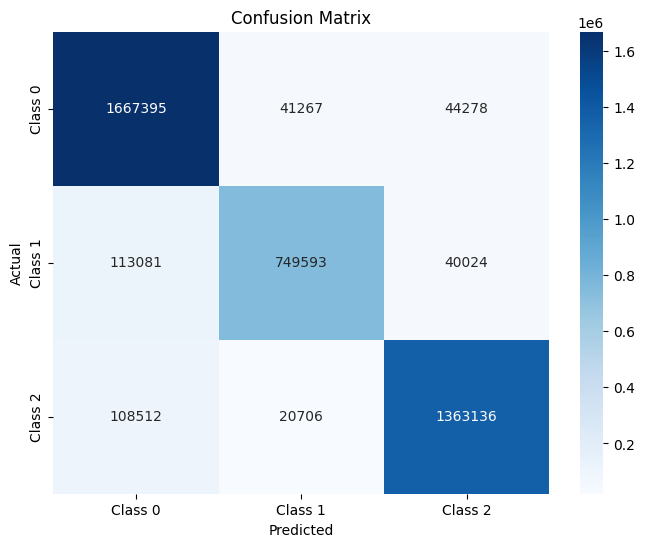

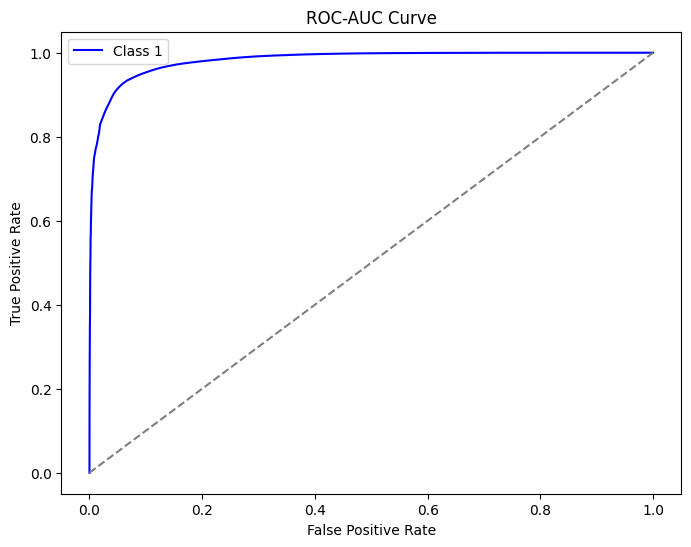

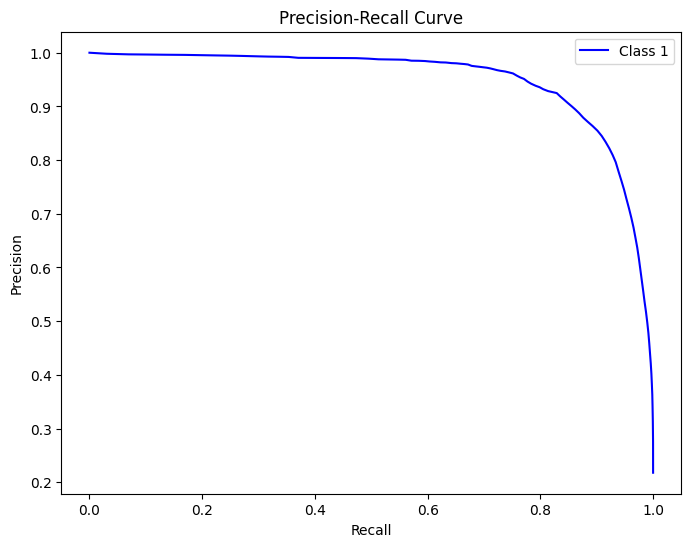

In [7]:
y_predict_validate = classifier.predict(df_validate)

print("Classification Report:", 
      metrics.classification_report(y_validate, y_predict_validate,
                                    zero_division=0), sep='\n')

matrix = metrics.confusion_matrix(y_validate, y_predict_validate)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob = classifier.predict_proba(df_validate)
fpr, tpr, _ = metrics.roc_curve(y_validate, y_prob[:, 1], pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='Class 1')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC-AUC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, _ = metrics.precision_recall_curve(y_validate, y_prob[:, 1], pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Class 1')
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [8]:
feat_importance = pd.DataFrame({
        'Columns': df_processed.columns, 
        'Importance': classifier.feature_importances_,
    })

feat_importance.sort_values('Importance', ascending = False)

,Columns,Importance
1,OrgId,2.196511e-01
2,IncidentId,1.357986e-01
4,DetectorId,9.523438e-02
3,AlertId,9.225233e-02
5,AlertTitle,7.682419e-02
0,Id,3.772017e-02
6,Category,3.739107e-02
47,TimestampDayofyear,2.516741e-02
45,TimestampDay,2.205530e-02
54,TimestampHour,2.185497e-02


<a id="conclude"></a>

### Conclusion

Though the scores might seem quite high for this level of data exploration, such results are unacceptable for cybersecurity. Having a miss may lead to an enormous amount of problems (data leak, money loss, legal problems, etc.). We can also notice from feature importances that a lot of event-, incident-specific features (by which I mean id's) influence the prediction significantly, leading to poor prediction and generalization. Also, I would like to notice that though SOC-features are not in the very top due to huge amount of missing data, they `have` an impact on prediction. That is also very bad as our target is predicted `before` SOC-analytics, so when predicting IncidentGrade we already have `some information about the future`, therefore not only `unfairly boosting the result of our model`, but also `performing actions unavailable in real life`. To sum up, the whole part of preprocessing is actually very useful as in this particular dataset it is expected that we know the data and its origin  

[Back to top](#plan)

<a id="bottom"></a>